<a href="https://colab.research.google.com/github/NadezhdaGruzdeva/A-B-testing/blob/main/HW8_A_B_Python_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Полезные ссылки:  
Загрузка дланнныых с гугл диск https://medium.com/geekculture/2-easy-ways-to-read-google-sheets-data-using-python-9e7ef366c775  
лекция https://gb.ru/lessons/316635  
оценка мощности https://machinelearningmastery.ru/statistical-power-and-power-analysis-in-python/

# A/B tests с Python




<a id="Libraries"></a>
##  Загрузка библиотек 

In [151]:
from scipy.stats import ttest_1samp, mannwhitneyu, shapiro
import numpy as np

from statsmodels.stats.power import TTestIndPower # estimate sample size via power analysis
        



In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


Dataset link   
https://docs.google.com/spreadsheets/d/1y7RvQGIjiFJ7RtZEngb6kty6pegrvpui/edit?usp=share_link&ouid=110449112515226114254&rtpof=true&sd=true


<a id="H0"></a>

##Тестирование гипотез

#Поработаем с датасетом

На сайте запущен А/В тест с целью увеличить доход.   

В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.  
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.


#Подготовка данных

In [153]:
#Подгружаем данные 

SHEET_ID = '1y7RvQGIjiFJ7RtZEngb6kty6pegrvpui'
SHEET_NAME = 'AAPL'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
data = pd.read_csv(url,decimal=',')
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2    REVENUE      10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [155]:
data.shape

(10000, 3)

In [156]:
# list(data.columns)
data.rename(columns = {' REVENUE':'REVENUE'}, inplace=True)

In [157]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


В датасете 3 столбца и 10 тыс. строк, уже судя по описанию столбца USER_ID понятно, что где-то значения дублируются

Найдем строки, с повторяющимеся значениями USER_ID	

In [158]:
data["USER_ID_count"]  = data.groupby(['USER_ID'])['REVENUE'].transform('count')
data.head()

,USER_ID,VARIANT_NAME,REVENUE,USER_ID_count
0,737,variant,0.0,2
1,2423,control,0.0,3
2,9411,control,0.0,2
3,7311,control,0.0,2
4,6174,variant,0.0,1


In [159]:
data[data['USER_ID_count']>1]


,USER_ID,VARIANT_NAME,REVENUE,USER_ID_count
0,737,variant,0.0,2
1,2423,control,0.0,3
2,9411,control,0.0,2
3,7311,control,0.0,2
6,2849,control,0.0,2
...,...,...,...,...
9992,9303,variant,0.0,2
9993,2400,variant,0.0,2
9994,3129,control,0.0,2
9995,1981,control,0.0,3


6.336 строк из 10.000 - данные по дублирующимся id. Данные для анализа
 собраны не корректно.
 Для дальнейшего анализа исключим строки с дубликатами ID из нашего датасета

In [160]:
data = data[data['USER_ID_count']==1]
data

,USER_ID,VARIANT_NAME,REVENUE,USER_ID_count
4,6174,variant,0.0,1
5,2380,variant,0.0,1
7,9168,control,0.0,1
10,8395,control,0.0,1
12,7165,control,0.0,1
...,...,...,...,...
9988,428,control,0.0,1
9991,8864,variant,0.0,1
9996,502,variant,0.0,1
9998,7741,control,0.0,1


In [161]:
data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE,USER_ID_count
count,1830.000000,1830.000000,1830.0
mean,4966.748087,0.066563,1.0
std,2916.198883,0.882727,0.0
min,4.000000,0.000000,1.0
25%,2393.500000,0.000000,1.0
50%,4973.000000,0.000000,1.0
75%,7418.750000,0.000000,1.0
max,9990.000000,23.040000,1.0


In [162]:
data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE,USER_ID_count
count,1834.000000,1834.000000,1834.0
mean,5049.845692,0.182694,1.0
std,2879.580387,4.653008,0.0
min,12.000000,0.000000,1.0
25%,2591.500000,0.000000,1.0
50%,5047.500000,0.000000,1.0
75%,7615.000000,0.000000,1.0
max,9998.000000,196.010000,1.0


В каждой группе осталось примерно одинаковое число пользователей.  
Пока мы еще ничего не посчитали, но уже можно заметить, что   
максимальный чек в контрольной группе намного больше (в 8,5 раз), чем в тестовой группе. Средний чек в контрольной группе также выше (примерно в 3 раза)

#Проверка на нормальность распределения и применение статистических критериев

##Метрика доход на юзера ARPU

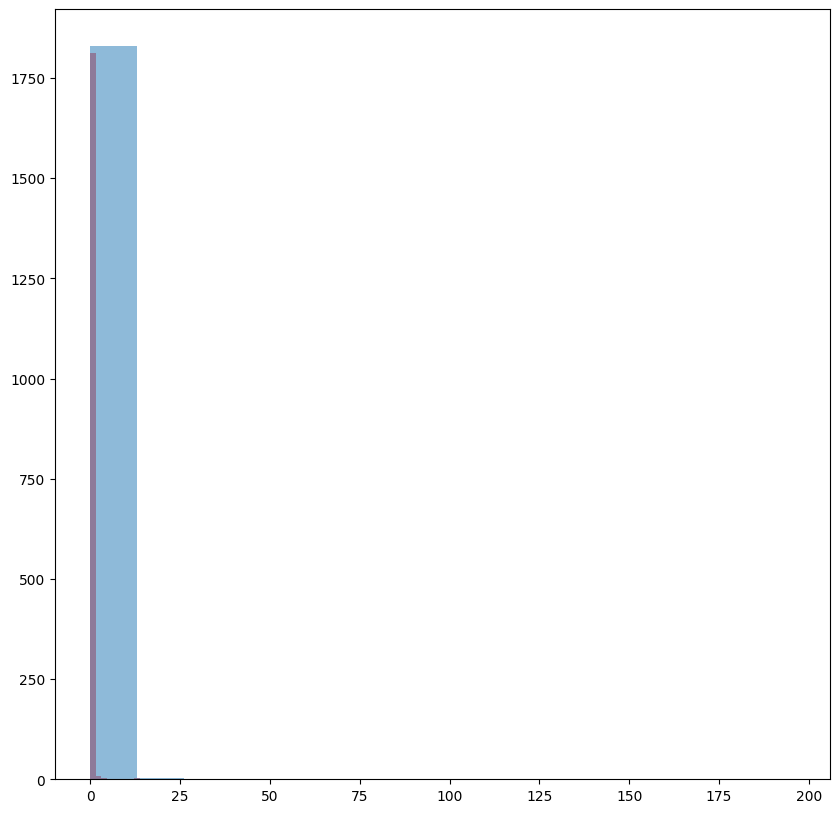

In [163]:
plt.figure(figsize=(10, 10))
control_visit_all = data['REVENUE'][data['VARIANT_NAME'] == 'variant']
test_visit_all =data['REVENUE'][data['VARIANT_NAME'] == 'control']


plt.hist(control_visit_all, color='r', bins=15, alpha = 0.5)
plt.hist(test_visit_all,  bins=15, alpha = 0.5)


plt.show()

Распределение точно не нормальное, выбоки независимые, 2 сравниваемых группы -   применяем Тест Манна Утни

In [164]:
alpha = 0.05

st = shapiro(data.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

Distribution is not normal



Тест Шапиро подтвердил ненормальность распределения

In [165]:
mw_stats = mannwhitneyu(x=data[(data['VARIANT_NAME'] == 'variant')&(data['REVENUE'] > 0)]['REVENUE'].values,
                                                  y=data[(data['VARIANT_NAME'] == 'control')&(data['REVENUE'] > 0)]['REVENUE'].values)
mw_stats

MannwhitneyuResult(statistic=366.5, pvalue=0.4094142137312685)

Несмотря на видимую разницу, тест Манна Уитни показал, что между группами нет статистически значимого различия

##Метрика доля юзеров с покупкой

Добавим столбец, отражающий была ли покупка (True - была, False - не было)

In [166]:
data['if_bought'] = np.where(data['REVENUE'] > 0, True, False)
# data.head(50)

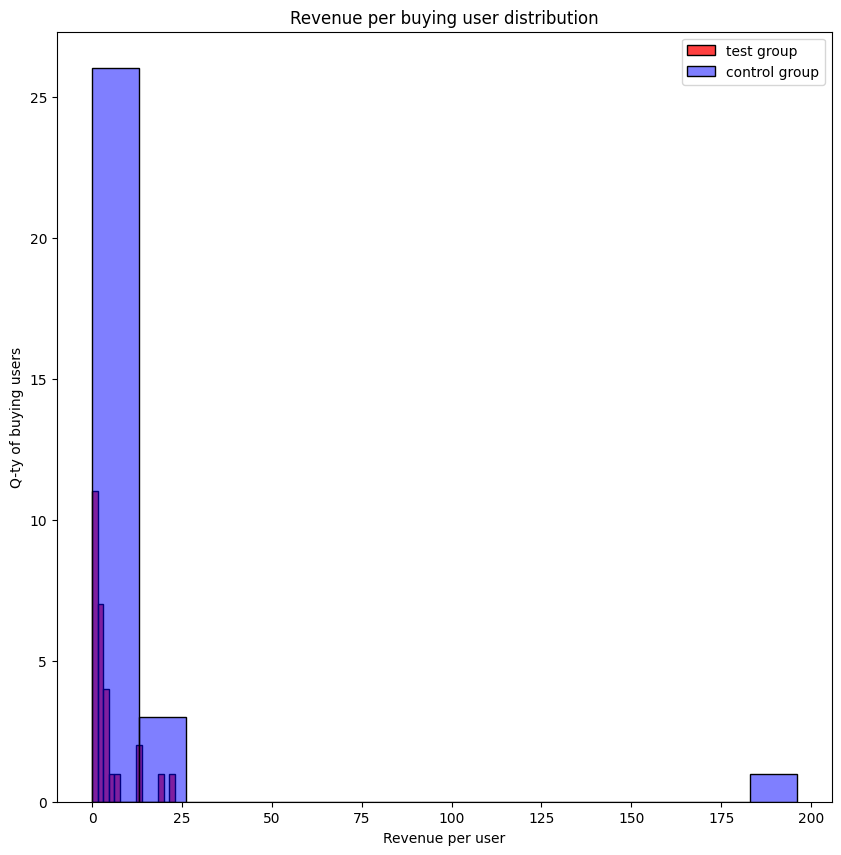

In [167]:
plt.figure(figsize=(10, 10))
control_revenue = data['REVENUE'][(data['VARIANT_NAME'] == 'control')&(data['if_bought'] == True)]
test_revenue =data['REVENUE'][(data['VARIANT_NAME'] == 'variant')&(data['if_bought'] == True)]
sns.histplot(test_revenue, color='r', bins=15, label='test group')
sns.histplot(control_revenue, color='b', bins=15, label='control group', alpha =0.5)
plt.title('Revenue per buying user distribution')
plt.xlabel('Revenue per user')
plt.ylabel('Q-ty of buying users')
plt.legend()
plt.show()

In [168]:
data['if_bought'].value_counts()

False    3606
True       58
Name: if_bought, dtype: int64

In [169]:
# Число юзеров, у которых была хотя бы 1 покупка
k1 = data[data['VARIANT_NAME'] == 'control']['if_bought'].sum()
k2 = data[data['VARIANT_NAME'] == 'variant']['if_bought'].sum()
k1, k2

(30, 28)

In [170]:
# Общее число юзеров
n1 = data[data['VARIANT_NAME'] == 'control'].shape[0]
n2 = data[data['VARIANT_NAME'] == 'variant'].shape[0]
n1, n2

(1834, 1830)

In [171]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                   np.array([n1, n2]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))

Results are  z_score =0.256, pvalue = 0.798


In [172]:
if abs(z_pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


Непараметрический Хи-квадрат

In [173]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                   np.array([n1, n2]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))

Results are  chisq =0.066, pvalue = 0.798


In [174]:
if abs(pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


Тесты Хи квадрат и z-тест для пропорций не показали статистически значимых различий между долями юзеров с покупкой от общего числа юзеров в контрольной и тествой группах

#Метрика ARPPU (доход на юзера с покупкой)


 Непараметрический критерий  Манн-Уитни

In [175]:
data_filtered = data[data['if_bought'] ==True]
data_filtered.groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,30.0,11.168667,35.235350,0.02,1.690,2.635,8.6600,196.01
variant,28.0,4.350357,5.784268,0.02,1.175,2.220,3.8675,23.04


In [176]:
mw_stats = mannwhitneyu(x=data[(data['VARIANT_NAME'] == 'variant')&(data['if_bought'] == True)]['REVENUE'].values,
                                                  y=data[(data['VARIANT_NAME'] == 'control')&(data['if_bought'] == True)]['REVENUE'].values)
mw_stats

MannwhitneyuResult(statistic=366.5, pvalue=0.4094142137312685)

Несмотря на видимые различия, тест Манна Уитни не показал, что есть статистически значимы различия

##Расчет мощности


*d* = (M1 – M2) / S_pooled






## S_pooled =

  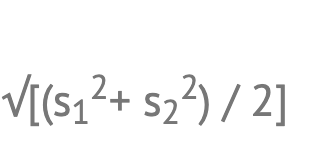

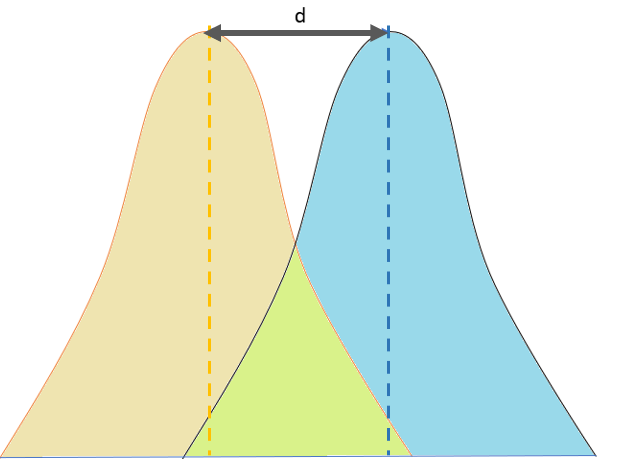

In [177]:
control = data.query('VARIANT_NAME == "control"')

test = data.query('VARIANT_NAME == "variant"')

In [178]:
C_mean = control.REVENUE.values.mean()

T_mean = test.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = test.REVENUE.values.std()

In [179]:
print(len(control.REVENUE.values), len(test.REVENUE.values))

1834 1830


In [180]:
n =  len(control.REVENUE.values)

In [181]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c)) #для неравных по размеру групп

S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [182]:
ef =float((T_mean-C_mean)/ S) 
effect = ef

In [183]:
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None,
nobs1=n, ratio=1.0, alpha=alpha)

result

0.18275886733310742

18% - это очень низкий результат статистической мощности, который говорит о том, что точность обнаружение каких либо связей очень мала

##Вывод:  
статистически значимых различий между контрольной и тестовой группы ни по одной из сл. метрик не выявлено:  
- ARPU  
- ARPPU  
- доля юзеров с покупкой.

Предоставленные для анализа данные содержат дубликаты client id, то есть одни и те же пользователи, заходящие с разных устройств попадают не только в датасет для анализа АБ теста, но и в сам анализ, что может иметь негативные последствия.   

Статистическая мощность теста мала, для достоверныхз выводов.